In [1]:
# importo librerias que voy a usar
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
pd.set_option('display.max_columns', None)
import re

In [2]:
# leo el data set
data = pd.read_csv("properati.csv")

In [3]:
# veo el tamaño del data set
data.shape

(121220, 26)

In [4]:
# veo porcentaje de nulos y agrego nuevas columnas al data frame que voy a modificar mas tarde
data['price_dolar'] = data['price_aprox_usd'].copy()
data["ambientes"] = data['rooms'].copy()
data["price_m2_dolar"] = data['price_usd_per_m2'].copy()
pct_nulos = data.isnull().sum() / data.shape[0]
pct_nulos

Unnamed: 0                    0.000000
operation                     0.000000
property_type                 0.000000
place_name                    0.000190
place_with_parent_names       0.000000
country_name                  0.000000
state_name                    0.000000
geonames_id                   0.154405
lat-lon                       0.425260
lat                           0.425260
lon                           0.425260
price                         0.168372
currency                      0.168380
price_aprox_local_currency    0.168372
price_aprox_usd               0.168372
surface_total_in_m2           0.324435
surface_covered_in_m2         0.164222
price_usd_per_m2              0.433947
price_per_m2                  0.276869
floor                         0.934837
rooms                         0.609058
expenses                      0.882346
properati_url                 0.000000
description                   0.000016
title                         0.000000
image_thumbnail          

## Veo la cantidad de duplicados

In [5]:
# veo cunatos duplicados voy a borrar 
desc_dupl = data.duplicated(subset=["property_type","place_name","geonames_id","lat-lon","price","surface_total_in_m2","surface_covered_in_m2","description"])
print("cantidad de duplicados a borrar", desc_dupl.sum())
sindesc_dupl = data.duplicated(subset=["property_type","place_name","geonames_id","lat-lon","price","surface_total_in_m2","surface_covered_in_m2"])
print("si saco la descripcion, podria borrar",sindesc_dupl.sum())

cantidad de duplicados a borrar 6069
si saco la descripcion, podria borrar 13873


In [6]:
# me fijo cuales son los que son duplicados sin la descripcion y que no estan en los duplicados que incluyen la descripcion
data.description[sindesc_dupl &  ~desc_dupl].head()

102    Tucuman 3476Edificio PB y 4 pisos por ascensor...
196    VENTA DE DEPARTAMENTO EN EDIFICIO A ESTRENAR E...
217    Zona residencial consolidad; con oferta gastro...
243    Departamento de un ambiente al contrafrente co...
459    Corredor Responsable: Mauro Marvisi - CMCPSI 5...
Name: description, dtype: object

In [7]:
# borro los duplicados, que en total son 6 mil. Las columnas que elegi para que se considere que es un duplicado son "property_type","place_name","geonames_id","lat-lon","price","surface_total_in_m2","surface_covered_in_m2","description"
data1 = data.drop_duplicates(subset=["property_type","place_name","geonames_id","lat-lon","price","surface_total_in_m2","surface_covered_in_m2","description"],keep="first")
data1.shape,data.shape

((115151, 29), (121220, 29))

## Veo las columnas referidas al precio

In [8]:
#me fijo si los nulos son iguales en las columnas de precios. 
print("cantidad de filas en data1:",data1.shape[0])
print("Si ambos tiene la misma cantidad de nulos y estan en las misma filas, al comparar price.isnull() == price_aprox_usd.isnull() y sumar los true deberia dar la mismas filas que el data frame:",(data1.price.isnull() == data1.price_aprox_usd.isnull()).sum())
print("Si ambos tiene la misma cantidad de nulos y estan en las misma filas, al comparar price.isnull() == price_aprox_local_currency.isnull() y sumar los true deberia dar la mismas filas que el data frame:",(data1.price.isnull() == data1.price_aprox_local_currency.isnull()).sum())

cantidad de filas en data1: 115151
Si ambos tiene la misma cantidad de nulos y estan en las misma filas, al comparar price.isnull() == price_aprox_usd.isnull() y sumar los true deberia dar la mismas filas que el data frame: 115151
Si ambos tiene la misma cantidad de nulos y estan en las misma filas, al comparar price.isnull() == price_aprox_local_currency.isnull() y sumar los true deberia dar la mismas filas que el data frame: 115151


In [9]:
# Me fijo si los nulos estan en la misma fila en ambas columnas, otra forma de lograr lo mismo que la celda anterior pero de forma diferente
set(data1.price.isnull().index).issubset(set(data1.price_aprox_usd.isnull().index))
set(data1.price.isnull().index).issubset(set(data1.price_aprox_local_currency.isnull().index))

True

## Empiezo a usar regex para completar los precios en dolares 

In [10]:
print("Cantidad de nulos en la culumna price_aprox_usd:",data1.price_aprox_usd.isnull().sum())

Cantidad de nulos en la culumna price_aprox_usd: 17269


In [11]:
# veo si puedo completar algun price nulo por lo que sale en la descripcion
mascara = data1.price_aprox_usd.isnull()
pd.set_option('display.max_colwidth', None)
price_nulo = data1[mascara].copy()

In [12]:
# veo el precio que hay en dolares en el titulo de la publicacion para completar nulos, con titulos relleno mas de 2000 precios
pat_tit1 = r'((([Uu][\$][Ss]?)|([Uu][Ss\$][Dd]{1}))+\s?(?P<precio>\d{2,3}[\.,]*\d{1,3}))'
regex_dol = re.compile(pat_tit1)
price_dolar_tit = price_nulo.title.apply(lambda x: regex_dol.search(str(x)))
price_dolar_tit.notnull().sum()
dolares_punto = price_dolar_tit[price_dolar_tit.notnull()].apply(lambda x: x.group('precio')).copy()
dolares_limpios = dolares_punto.apply(lambda x: re.compile("\.").sub("",x))
dolares_limpios_final = dolares_punto.apply(lambda x: re.compile("\.").sub("",x)).copy()
data1.loc[dolares_limpios.index,'price_dolar'] = dolares_limpios_final.astype(float).copy()

C:\ProgramData\Anaconda3\envs\dhdsblend\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [13]:
# logro bajar 2% de nulos 
data1['price_dolar'].isnull().sum()/ data1.shape[0], data1['price_aprox_usd'].isnull().sum() / data1.shape[0]

(0.13174874729702737, 0.1499683024897743)

In [14]:
# quedaron 15171 nulos en la columna price_dolar
pd.set_option('display.max_rows',200)
data1[data1['price_dolar'].isnull()].title.sample(200)
data1['price_dolar'].isnull().sum()

15171

## veo los valores que hay en pesos en la culumna title y description 

In [15]:
# pat_pesos = r'(([\$]+)\s?(?P<precio>\d{1,3}[\.,]*\d{1,3}[\.,]*\d{0,3}))'
pat_pesos1 = r'(?P<pesos>([\$]+)\s?(?P<precio>\d{0,3}[\.,]?\d{3}[\.,]?\d{3}))'
regexs_peso = re.compile(pat_pesos1)
pesos_tit = price_nulo.title.apply(lambda x: regexs_peso.search(str(x)))
price_nulo.loc[pesos_tit.notnull(),"title"]
pesos_tit.notnull().sum()
# logro quedarme con 172 precios hay que ver como pasarlos a dolares 

172

In [16]:
# ahora me fijo si en la descripcion hay valores en pesos, tengo que revisar el patron porque toma algunos valores en dolares
# data1.price_aprox_local_currency.max()
pat_pesos2 = r'(?P<pesos>([\$]+)\s?(?P<precio>\d{0,2}[\.,]*\d{3}[\.,]*\d{3}))'
regex_pesos = re.compile(pat_pesos2)
pesos = price_nulo.description.apply(lambda x: regex_pesos.search(str(x)))
pesos.notnull().sum()
price_nulo[pesos.notnull()].description.head()

1725                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              2 DORMITORIOS Y MEDIO     1 SOLO  BAÑO (NO TIENE BAÑERA)    AMPLIO BALCON QUE UNE TODO EL FRENTE DEL DPTO (ACCESO POR LIVING COMEDOR Y POR EL DORMITORIO    UBICACION FRENTE  ( calle Hilario Fernandez Nueva Cordoba)    COCHERA: NO TIENE    TITULO:

## Empiezo a completar la columna ambientes

In [17]:
# creo un data frame donde los valores de rooms sean nulos 
sin_amb = data1[data1.rooms.isnull()]['description']

In [18]:
# En el patron busco los que salen con ambientes y tambien dormitorios, en las description de las filas que rooms es nulo 
pat_amb1 = r'(?P<todo>(?P<numero>\d{1,2})\s?[Aa][Mm][Bb])'
pat_amb2 = r'(?P<todo>(?P<numero>\d{1,2})\s?[Dd][Oo][Rr][Mm])'
regex_amb = re.compile(pat_amb1)
regex_amb2 = re.compile(pat_amb2)
ambientes = sin_amb.apply(lambda x: regex_amb.search(str(x)))
dormitorio = sin_amb.apply(lambda x: regex_amb2.search(str(x)))
amb_dorm = (ambientes.notnull() & dormitorio.notnull())
dorm = dormitorio.notnull() & ~amb_dorm

In [19]:
# mediante iloc seleciono los ambientes y dormitorios que encontre se los completo a la columna ambientes. tengo cuidado de de que los que coincidan en tener match de ambientes y dormitorios pongo solo el match de ambientes 
data1.loc[ambientes[ambientes.notnull()].index,"ambientes"] = ambientes[ambientes.notnull()].apply(lambda x: x.group("numero")).copy()
data1.loc[dorm.index[dorm],"ambientes"] = dormitorio[dorm.index[dorm]].apply(lambda x: x.group("numero")).copy()
# data1.loc[ambientes[ambientes.notnull()].index,"ambientes"]
# sin_amb.loc[ambientes.notnull()]

In [20]:
#  me fijo si con otro patron puedo encontrar mas ambientes para rellenar con otro patron, encontre que puedo añadir 57 datos mas, ya que tengo que tener en cuenta que no esten en los otros dos patrones que busque antes
patron_amb2 =  r'[Aa][Mm][Bb][Ii][Ee][Nn][Tt][Ee][sS]*\s?[\s:]?\s?(?P<numero>\d{1,2})'
regex_amb1 = re.compile(patron_amb2)
ambientes1 = sin_amb.apply(lambda x: regex_amb1.search(str(x)))
amb1y2 = ambientes.notnull() & ambientes1.notnull()
amb_dorm = ambientes1.notnull() & dormitorio.notnull()
amb1_sim_amb= ambientes1.notnull() & ~amb1y2
ambientes_otro_pat = amb1_sim_amb & amb_dorm
data1.loc[ambientes_otro_pat.index[ambientes_otro_pat],"ambientes"] = ambientes1[ambientes_otro_pat].apply(lambda x: x.group("numero")).copy()

In [21]:
# con esto me fijo cual es el nuevo porcentaje de nulos que tengo y el que tenia. Bajo mas de un 30% los nulos 
data1.ambientes.isnull().sum() / data1.shape[0], data.ambientes.isnull().sum() / data.shape[0]

(0.28314995093399103, 0.6090579112357697)

# pileta 

In [22]:
#Hago un regex para saber si tiene pileta  
pat_pile = r'(?P<pileta>([Pp]ileta)|([Pp]iscina)s?)'
regex_pile = re.compile(pat_pile)
pileta1= data1.description.apply(lambda x: regex_pile.search(str(x)))
pileta1

0                                                       None
1                                                       None
2                                                       None
3                                                       None
4                                                       None
                                 ...                        
121215    <re.Match object; span=(287, 293), match='pileta'>
121216    <re.Match object; span=(883, 889), match='pileta'>
121217                                                  None
121218                                                  None
121219                                                  None
Name: description, Length: 115151, dtype: object

In [23]:
# creo la columna pileta, asignandole 1 si tiene y 0 sino tiene 
data1.loc[pileta1.notnull(),'pileta'] = 1
data1.loc[pileta1.isnull(),'pileta'] = 0
data1.pileta

C:\ProgramData\Anaconda3\envs\dhdsblend\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
121215    1.0
121216    1.0
121217    0.0
121218    0.0
121219    0.0
Name: pileta, Length: 115151, dtype: float64

In [24]:
# ver esas 2 filas que no tienen descripcion 
data1[data1.description.isnull()]

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,price_dolar,ambientes,price_m2_dolar,pileta
10664,10664,sell,apartment,Villa Carlos Paz,|Argentina|Córdoba|Villa Carlos Paz|,Argentina,Córdoba,3832791.0,"-31.4207828,-64.4992141",-31.420783,-64.499214,2350000.0,ARS,2325485.81,131796.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/168nc_venta_departamento_villa-carlos-paz_balcon_piscina_quincho_garage_aire-acondicionado_tallarico-prop,NaN,HERMOSO DEPARTAMENTO CON PISCINA Y COCHERA,https://thumbs4.properati.com/6/JiAoy6zsKPeBobswP_iNIel8FQg=/trim/198x0/smart/filters:strip_icc()/tallarico.com.ar/photos/0048-14581583_1801604653396132_6593153683997444430_n%20(1).jpg,131796.64,NaN,NaN,0.0
96691,96691,sell,apartment,San Fernando,|Argentina|Bs.As. G.B.A. Zona Norte|San Fernando|,Argentina,Bs.As. G.B.A. Zona Norte,3429088.0,NaN,NaN,NaN,98000.0,USD,1729161.00,98000.00,NaN,55.0,NaN,1781.818182,NaN,NaN,NaN,http://www.properati.com.ar/1bj1r_venta_departamento_san-fernando_dl-delcastilloprop,NaN,Departamento - San Fernando,https://thumbs4.properati.com/1/FZZcNCsb4-ucU2tHZzcGnz9cAXc=/trim/198x0/smart/filters:strip_icc()/tbcn.s3-accelerate.amazonaws.com/pictures/97167690691021099014876125662787939056761097664237264318413016129438379680395.jpg,98000.00,NaN,NaN,0.0


In [25]:
pct_nulos1 = data1.isnull().sum() / data1.shape[0]
pct_nulos,pct_nulos1 

(Unnamed: 0                    0.000000
 operation                     0.000000
 property_type                 0.000000
 place_name                    0.000190
 place_with_parent_names       0.000000
 country_name                  0.000000
 state_name                    0.000000
 geonames_id                   0.154405
 lat-lon                       0.425260
 lat                           0.425260
 lon                           0.425260
 price                         0.168372
 currency                      0.168380
 price_aprox_local_currency    0.168372
 price_aprox_usd               0.168372
 surface_total_in_m2           0.324435
 surface_covered_in_m2         0.164222
 price_usd_per_m2              0.433947
 price_per_m2                  0.276869
 floor                         0.934837
 rooms                         0.609058
 expenses                      0.882346
 properati_url                 0.000000
 description                   0.000016
 title                         0.000000


In [26]:
((data.price_dolar.isnull()) & (data1.surface_covered_in_m2.notnull())).sum()

11414

In [27]:
data1[data.price_dolar.isnull()][["surface_total_in_m2","surface_covered_in_m2","price_usd_per_m2","price_per_m2"]]

C:\ProgramData\Anaconda3\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2
5,53.0,NaN,NaN,NaN
20,148.0,148.0,NaN,NaN
41,115.0,115.0,NaN,NaN
62,156.0,156.0,NaN,NaN
67,220.0,NaN,NaN,NaN
...,...,...,...,...
121210,NaN,120.0,NaN,NaN
121211,205.0,205.0,NaN,NaN
121212,420.0,420.0,NaN,NaN
121213,600.0,600.0,NaN,NaN


In [28]:
data1[data1.property_type == "apartment"][["surface_total_in_m2","surface_covered_in_m2"]][:50]

,surface_total_in_m2,surface_covered_in_m2
1,NaN,NaN
2,55.0,55.0
4,35.0,35.0
7,45.0,40.0
8,65.0,60.0
12,39.0,36.0
13,50.0,30.0
14,42.0,31.0
17,176.0,78.0
19,104.0,96.0


## Empiezo con los ambientes, trato de completarlos

In [80]:
# patron_m2 =  r'(\d{1,3}[\.,]?\d{0,3})\s?(([Mm]2)|([Mm][Tt][Ss]2?))\s?([Dd][Ee])?[Tt][Ee][Rr][Rr][Ee]'
# patron_m2 =  r'[Tt][Ee][Rr][Rr][Ee][Nn][Oo]([Dd][Ee])?(\d{1,3}[\.,]?\d{0,3})\s?(([Mm]2)|([Mm][Tt][Ss]2?))'
patron_m2 =  r'(\d{1,3}[\.,]?\d{0,3})\s?(([Mm]2)|([Mm][Tt][Ss]2?))\s?([Dd][Ee])?[Ss][Uu][Pp]'
# patron_m2 =  r'[Ss][Uu][Pp][Ee][Rr][Ff][Ii][Cc][Ii][Ee]([Dd][Ee])?(\d{1,3}[\.,]?\d{0,3})\s?(([Mm]2)|([Mm][Tt][Ss]2?))?'
#con esos dos patrones de arriba saco solamente 50 registros
# patron_m2 =  r'(\d{1,3}[\.,]?\d{0,3})\s?(([Mm]2)|([Mm][Tt][Ss]2?))\s?[Tt][Oo][Tt]'
# patron_m2_cov =  r'[Mm]2'
patron_m2_cov = r'(\d{1,3}[\.,]?\d{0,3})\s?(([Mm]2)|([Mm][Tt][Ss]2?))\s?[Cc][Uu][Bb]'
regex_m2 = re.compile(patron_m2)
regex_m2_cov = re.compile(patron_m2_cov)
m2_tot_null = data1[data1.surface_total_in_m2.isnull()].description
m2_cov_null = data1[data1.surface_covered_in_m2.isnull()].description
# (m2_tot_null.apply(lambda x: regex_m2.search(str(x)))).notnull().sum()
# (m2_cov_null.apply(lambda x: regex_m2_cov.search(str(x)))).notnull().sum()
m2_cov_null[(m2_cov_null.apply(lambda x: regex_m2_cov.search(str(x)))).notnull()].sample(5)
# ,indice_cuv
# pd.set_option("max_colwidth",None)
# m2_tot_null

37436     Corredor Responsable: Real Estate New Generation S.A. - C.C.P.I.M 0001- S.A.- 2011Contacto: Lucia Chalier - MLS ID # 420131006-350Ubicada en la calle Alberti de Godoy Cruz, de 16 años de antiguedad, sobre un terreno de 202 m2 y 184 m2 cubiertos, esta hermosa casa de categoría cuenta con enrejado y chapa ciega al frente, cochera cubierta doble en paralelo, ingreso al amplio living comedor en desnivel y con ventana bowindow. Cocina comedor con salida al patio, pasillo de distribución con placard, habitación en planta baja con amplio placard, baño completo con mampara, escalera de acceso a planta alta, lavandería y salida al jardín. En planta alta, dos amplias habitaciones con placares, baño con antebaño y pequeño escritorio. Patio jardín con churrasquera y placard de guardado, mesada con bajo mesada, bacha, puerta metálica. Detalles: Escalera con diseño en hierro macizo y escalones de roble macizo lustrado. estar que distribuye a los dormitorios, antebaño con mueble bajo mesada

In [30]:
# quiero ver de donde sale el precio por metro cuadrado 
preciom2_total_pesos = data1.price_aprox_local_currency / data1.surface_total_in_m2
preciom2_total_usd = data1.price_aprox_usd / data1.surface_total_in_m2
preciom2_cov_pesos = data1.price_aprox_local_currency / data1.surface_covered_in_m2
preciom2_cov_usd = data1.price_aprox_usd / data1.surface_covered_in_m2
preciom2_total = data1.price / data1.surface_total_in_m2
preciom2_total_cov = data1.price / data1.surface_covered_in_m2
preciom2_total_price_dolar = data1.price_dolar / data1.surface_total_in_m2
preciom2_cov_price_dolar = data1.price_dolar / data1.surface_covered_in_m2
data1["pricem2_covered_usd"] = (data1.price_dolar / data1.surface_covered_in_m2).copy()
data1["pricem2_total_usd"] = (data1.price_dolar / data1.surface_total_in_m2).copy()

C:\ProgramData\Anaconda3\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [31]:
# (preciom2 == data.price_per_m2).sum(),(preciom2usd == data.price_usd_per_m2).sum(),(preciototal == data.price_usd_per_m2).sum(),(preciototal == data.price_per_m2).sum(),(preciototal_cov == data.price_per_m2).sum()
# preciom2cov = data.price_aprox_local_currency / data.price_per_m2
# veo el total de resultados que obtuve 
# (preciototal == data.price_usd_per_m2).sum() + (preciototal == data.price_per_m2).sum() + (preciototal_cov == data.price_per_m2).sum(),

In [32]:
# print("precio por m2 total en pesos\n",preciom2_total_pesos)
# print("precio por m2 total en pesos, columna price\n",preciom2_total)
print("cantidad de precios iguales entre precio por m2 total de la columna price y price_per_m2\n",(round(preciom2_total,-2) == round(data1.price_per_m2,-2)).sum())
print("cantidad de precios iguales entre precio por m2 cubierto de la columna price y price_per_m2\n",(round(preciom2_total_cov,-2) == round(data1.price_per_m2,-2)).sum())
print("cantidad de precios iguales entre precio por m2 total de la columna price y price_usd_per_m2\n",(round(preciom2_total,-2) == round(data1.price_usd_per_m2,-2)).sum())
print("cantidad de precios iguales entre precio por m2 cubierto de la columna price y price_usd_per_m2\n",(round(preciom2_total_cov,-2) == round(data1.price_usd_per_m2,-2)).sum())
print("cantidad de precios iguales entre precio por m2 total en pesos y price_per_m2\n",(round(preciom2_total_pesos,-2) == round(data1.price_per_m2,-2)).sum())
print("cantidad de precios iguales entre precio por m2 cubierto en pesos y price_per_m2\n",(round(preciom2_cov_pesos,-2) == round(data1.price_per_m2,-2)).sum())
print("cantidad de precios iguales entre precio por m2 total en dolares y price_per_m2\n",(round(preciom2_total_usd,-2) == round(data1.price_per_m2,-2)).sum())
print("cantidad de precios iguales entre precio por m2 cubiert en dolares y price_per_m2\n",(round(preciom2_cov_usd,-2) == round(data1.price_per_m2,-2)).sum())
print("cantidad de precios iguales entre precio por m2 total en dolares y price_usd_per_m2 \n",(round(preciom2_total_usd,-2) == round(data1.price_usd_per_m2,-2)).sum())
print("cantidad de precios iguales entre precio por m2 cubiert en dolares y price_usd_per_m2 \n",(round(preciom2_cov_usd,-2) == round(data1.price_usd_per_m2,-2)).sum())
print("cantidad de precios iguales entre precio por m2 total DE LA COLUMNA PRICE_DOLAR y price_usd_per_m2 \n",(round(preciom2_total_price_dolar,-2) == round(data1.price_usd_per_m2,-2)).sum())
print("cantidad de precios iguales entre precio por m2 cubiert DE LA COLUMNA PRICE DOLAR y price_usd_per_m2 \n",(round(preciom2_cov_price_dolar,-2) == round(data1.price_usd_per_m2,-2)).sum())
print("cantidad entradas no nulos en data.price_per_m2\n",data1.price_per_m2.notnull().sum())
print("cantidad entradas no nulos en data.price_usd_per_m2\n",data1.price_usd_per_m2.notnull().sum())

cantidad de precios iguales entre precio por m2 total de la columna price y price_per_m2
 20719
cantidad de precios iguales entre precio por m2 cubierto de la columna price y price_per_m2
 85043
cantidad de precios iguales entre precio por m2 total de la columna price y price_usd_per_m2
 58348
cantidad de precios iguales entre precio por m2 cubierto de la columna price y price_usd_per_m2
 18703
cantidad de precios iguales entre precio por m2 total en pesos y price_per_m2
 74
cantidad de precios iguales entre precio por m2 cubierto en pesos y price_per_m2
 276
cantidad de precios iguales entre precio por m2 total en dolares y price_per_m2
 18703
cantidad de precios iguales entre precio por m2 cubiert en dolares y price_per_m2
 75156
cantidad de precios iguales entre precio por m2 total en dolares y price_usd_per_m2 
 66318
cantidad de precios iguales entre precio por m2 cubiert en dolares y price_usd_per_m2 
 20884
cantidad de precios iguales entre precio por m2 total DE LA COLUMNA PRIC

In [33]:
preciom2_total_cov.notnull().sum()
preciom2_cov_price_dolar.notnull().sum()

87074

# de esto saco que price_per_m2 es de la superficie cubierta 

In [34]:
data1.price_per_m2

0         1550.000000
1                 NaN
2         1309.090909
3                 NaN
4         1828.571429
             ...     
121215    9354.838710
121216    1383.333333
121217    3371.794872
121218    1997.916667
121219    1675.324675
Name: price_per_m2, Length: 115151, dtype: float64

In [35]:
# me fijo que tengo 249 registros que obtuve de dividir la columna price_aprox_usd en los metros cuadrados totales, y obtuve 1780 registros si uso la columna price_dolar que cree 
# (preciom2_total_usd.notnull() & data.price_usd_per_m2.isnull()).sum(),(preciom2_total_price_dolar.notnull() & data.price_usd_per_m2.isnull()).sum(),preciom2_total_usd.notnull().sum(),data.price_usd_per_m2.notnull().sum()
mascara_m2_dolar = preciom2_total_price_dolar.notnull() & data.price_usd_per_m2.isnull()
precio_m2_dolares = preciom2_total_price_dolar[mascara_m2_dolar]
precio_m2_dolares.replace([np.inf,-np.inf],np.NaN,inplace=True)
precio_m2_dolares.dropna(how="all",inplace=True)
indices = precio_m2_dolares.index
data1.loc[indices,"price_m2_dolar"] = precio_m2_dolares.copy()
precio_m2_dolares.count()

C:\ProgramData\Anaconda3\envs\dhdsblend\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1780

In [36]:
# Me di cuenta que todos los registros que son iguales a preciom2_total == data1.price_per_m2 estan contenidos en preciom2_total_cov == data1.price_per_m2 pasa lo mismo con la columna de dolares 
((preciom2_total == data1.price_per_m2)  & (preciom2_total_cov == data1.price_per_m2)).sum()
set(preciom2_total[preciom2_total == data1.price_per_m2]).issubset(set(preciom2_total_cov[preciom2_total_cov == data1.price_per_m2])),set(preciom2_total_usd[preciom2_total_usd == data1.price_per_m2]).issubset(set(preciom2_cov_usd[preciom2_cov_usd == data1.price_per_m2]))

(True, True)

In [37]:
# Al contrario de lo que pasa en la columna price_per_m2, ahora hay mas registros iguales en la columna de preciom2_total_usd y la variable preciom2_cov_usd es un subcojunto de esta cuando la igualo a price_usd_per_m2. lo mismo para la columna price
set(preciom2_cov_usd[preciom2_cov_usd == data1.price_usd_per_m2]).issubset(set(preciom2_total_usd[preciom2_total_usd == data1.price_usd_per_m2]))
set(preciom2_total_cov[preciom2_total_cov == data1.price_usd_per_m2]).issubset(set(preciom2_total[preciom2_total == data1.price_usd_per_m2]))
set(preciom2_cov_usd[preciom2_cov_usd == data1.price_usd_per_m2]).issubset(set(preciom2_total_cov[preciom2_total_cov == data1.price_usd_per_m2]))
((preciom2_total_cov == data1.price_per_m2)  & (preciom2_cov_usd == data1.price_per_m2)).sum()
# preciom2_total_usd == data1.price_usd_per_m2

51485

In [38]:
(data1["price"] == data1["price_aprox_usd"]).sum(),data1["price"].notnull().sum(),data1["price_aprox_usd"].notnull().sum()

(85325, 97882, 97882)

In [39]:
(data1["price"] == data1["price_aprox_local_currency"]).sum(),data1["price"].notnull().sum(),data1["price_aprox_local_currency"].notnull().sum()

(1, 97882, 97882)

In [41]:
# quiero ver  cuales son los precio por m2 que estan en pesos, si redondeo encuentro mas que coinciden 
mascara_pesos = (data1[data1.price.notnull()]["price"] != data1[data1.price_aprox_usd.notnull()]["price_aprox_usd"])
data1_price_notnull = data1[data1.price.notnull()].price
preciom2_total_pesos_masc = data1_price_notnull[mascara_pesos].round() / data1.loc[mascara_pesos.index].surface_total_in_m2
# (preciom2_total_pesos_masc.round(-2) == data1.price_per_m2.loc[mascara.index].round(-2)).sum()
# preciom2_total_pesos_masc[preciom2_total_pesos_masc.notnull()].round(-3)
# data1_price_notnull[mascara_pesos]
# data1.price / data1.surface_total_in_m2
# preciom2_total_cov = data1.price / data1.surface_covered_in_m2
# (preciom2_total[mascara_pesos] == data1.price_per_m2).sum()
# (preciom2_total_cov == data1.price_per_m2)

In [42]:
pd.set_option("display.max_rows",100)
precios = data1[data1["price"] != data1["price_aprox_usd"]]
precios[precios.price.notnull()][['price',"price_aprox_usd","price_aprox_local_currency"]].sample(20).round(-4)
# data1[data1["price"] != data1["price_aprox_usd"]][['price',"price_aprox_usd","price_aprox_local_currency"]] 

,price,price_aprox_usd,price_aprox_local_currency
54964,1000000.0,60000.0,990000.0
67628,1440000.0,80000.0,1420000.0
112845,5860000.0,330000.0,5800000.0
120426,1400000.0,80000.0,1390000.0
45857,780000.0,40000.0,770000.0
37433,2320000.0,130000.0,2300000.0
94740,1830000.0,100000.0,1810000.0
15227,5340000.0,300000.0,5280000.0
13945,770000.0,40000.0,760000.0
72660,4080000.0,230000.0,4040000.0


<h1>matriz de correlacion<h1>

In [51]:
data1['ambientes'] = data1.ambientes.astype(float)

C:\ProgramData\Anaconda3\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [52]:
data1.keys()

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail', 'price_dolar', 'ambientes', 'price_m2_dolar',
       'pileta', 'pricem2_covered_usd', 'pricem2_total_usd'],
      dtype='object')

In [53]:
correlacion = data1[['price_dolar','surface_total_in_m2',
       'surface_covered_in_m2','expenses','ambientes','pileta', 'pricem2_covered_usd', 'pricem2_total_usd']]
corr = correlacion.corr()
corr.style.background_gradient(cmap='coolwarm')

,price_dolar,surface_total_in_m2,surface_covered_in_m2,expenses,ambientes,pileta,pricem2_covered_usd,pricem2_total_usd
price_dolar,1.000000,0.309042,0.166628,0.010378,0.140861,0.165906,0.098629,0.308375
surface_total_in_m2,0.309042,1.000000,0.205837,-0.000034,0.062185,0.046011,-0.005714,-0.050416
surface_covered_in_m2,0.166628,0.205837,1.000000,0.000762,0.048540,0.035426,-0.012459,-0.051303
expenses,0.010378,-0.000034,0.000762,1.000000,-0.001573,0.001696,0.001220,0.016302
ambientes,0.140861,0.062185,0.048540,-0.001573,1.000000,0.045846,0.018394,-0.091501
pileta,0.165906,0.046011,0.035426,0.001696,0.045846,1.000000,0.005372,0.010305
pricem2_covered_usd,0.098629,-0.005714,-0.012459,0.001220,0.018394,0.005372,1.000000,0.335226
pricem2_total_usd,0.308375,-0.050416,-0.051303,0.016302,-0.091501,0.010305,0.335226,1.000000


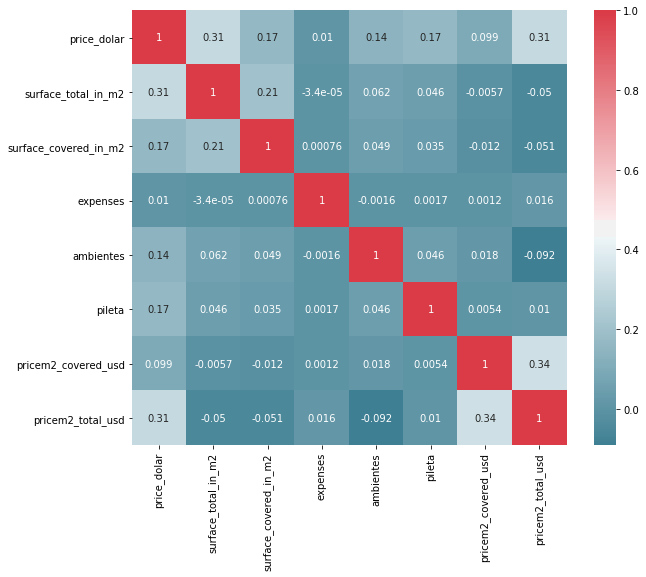

In [169]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

<h2>Empiezo con los graficos<h2>

In [55]:
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [ ]:
# titanic = sns.load_dataset("titanic")
g = sns.catplot("alive", col="deck", col_wrap=4,
                data=titanic[titanic.deck.notnull()],
                kind="count", height=2.5, aspect=.8)

In [73]:
type(pct_nulos1)
nulos_graf = pd.DataFrame(pct_nulos1[["price_aprox_usd","price_dolar","rooms","ambientes"]]*100,columns=["Nulos"])
nulos_graf["variables"] = ["price_dolar","price_dolar","rooms","rooms"]
nulos_graf["cuando"] = ["Antes","Despues","Antes","Despues"]
nulos_graf
 # pd.DataFrame(data =[pct_nulos1[["price_aprox_usd","price_dolar","rooms","ambientes"]].values,["antes"]])
# pct_nulos1[["price_aprox_usd","price_dolar","rooms","ambientes"]].values

,Nulos,variables,cuando
price_aprox_usd,14.996830,price_dolar,Antes
price_dolar,13.174875,price_dolar,Despues
rooms,60.279112,rooms,Antes
ambientes,28.314995,rooms,Despues


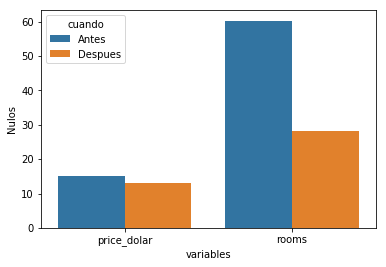

In [79]:
grafico_nulos = sns.barplot(x="variables", y="Nulos", hue="cuando", data=nulos_graf)
grafico_nulos.

In [100]:
data1.keys()

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail', 'price_dolar', 'ambientes', 'price_m2_dolar',
       'pileta', 'pricem2_covered_usd', 'pricem2_total_usd'],
      dtype='object')

In [104]:
pairplot = data1[['price_dolar','surface_total_in_m2','surface_covered_in_m2','ambientes','pileta']].copy()
pairplot.dropna(axis=0,how="all",subset=["price_dolar"],inplace=True)
pairplot.drop(pairplot[pairplot.price_dolar <= 0].index,inplace=True)
pairplot["price_dolar"] = np.log(pairplot["price_dolar"])

In [115]:
pairplot.describe()

,price_dolar,surface_total_in_m2,surface_covered_in_m2,ambientes,pileta
count,99979.000000,68347.000000,87074.000000,72929.000000,99979.000000
mean,11.993561,228.703937,131.002217,2.915809,0.237520
std,0.809058,1714.419825,748.874797,2.242195,0.425566
min,5.834811,0.000000,0.000000,0.000000,0.000000
25%,11.407565,50.000000,45.000000,2.000000,0.000000
50%,11.884489,85.000000,75.000000,3.000000,0.000000
75%,12.487840,205.000000,150.000000,4.000000,0.000000
max,17.655940,200000.000000,187000.000000,91.000000,1.000000


In [153]:
type(lim_sup(pairplot['surface_total_in_m2']))
# pairplot.surface_total_in_m2.quantile(q=0.75)
lim_sup(pairplot1.surface_total_in_m2)

398.5

In [164]:
def lim_inf(serie):
    q1 = serie.quantile(q=0.25)
    q3 = serie.quantile(q=0.75)
    lim_inf = q1 - (q3-q1) * 1.5
    return lim_inf
def lim_sup(serie):
    q1 = serie.quantile(q=0.25)
    q3 = serie.quantile(q=0.75)
    lim_sup= q3 + (q3-q1)*1.5
    return lim_sup
pairplot1 = pairplot[(pairplot.ambientes > lim_inf(pairplot.ambientes)) & (pairplot.ambientes <= lim_sup(pairplot.ambientes))]
pairplot2 = pairplot1[(pairplot1.surface_total_in_m2 >= lim_inf(pairplot1.surface_total_in_m2)) & (pairplot1.surface_total_in_m2 <= lim_sup(pairplot1.surface_total_in_m2))]
pairplot3 = pairplot2[(pairplot2.surface_covered_in_m2 >= lim_inf(pairplot2.surface_covered_in_m2)) & (pairplot2.surface_covered_in_m2 <= lim_sup(pairplot2.surface_covered_in_m2))]
# pairplot.surface_total_in_m2 > lim_inf(pairplot.surface_total_in_m2)

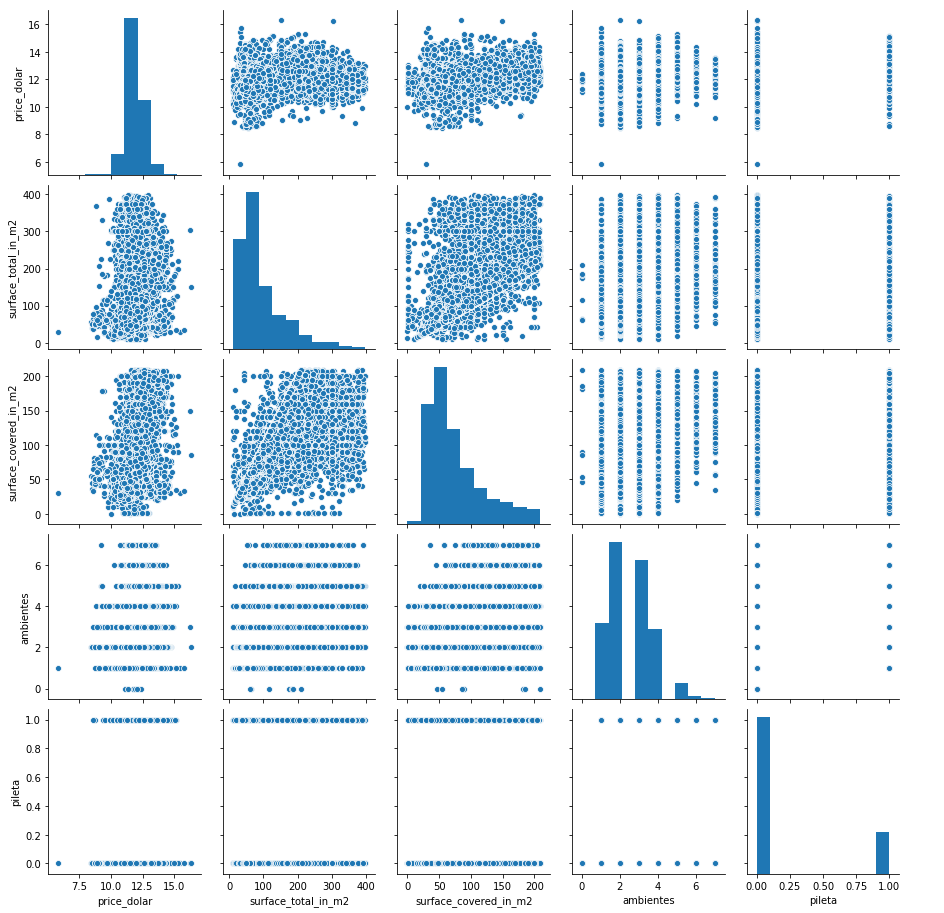

In [165]:
sns.pairplot(data=pairplot3)

## Empiezo con geonames id

In [ ]:
geoid_tot= data1.groupby("place_name").geonames_id.value_counts()
place_sin_geoid= data1[data1.geonames_id.isnull()].groupby("place_name").geonames_id.count()

In [ ]:
grupos_id = data1.groupby("place_name")["geonames_id"].value_counts()
grupos_id.loc["San Miguel"]

In [ ]:
data1.keys()

In [ ]:
# grupos_id.loc[row.pla].index[0]
prueba = data1[data1.geonames_id.isnull()]

In [ ]:
# for index,row in data1[data1.geonames_id.isnull()].iterrows():
contador = 0
for index,row in data1.iterrows():
    if np.isnan(row.geonames_id):
        try:
            row.geonames_id = grupos_id.loc[row.place_name].index[0]
        except:
            contador +=1
contador        
#     except:
#         print(row.place_name)

In [ ]:
data1.geonames_id.isnull().sum(),data.geonames_id.isnull().sum()

In [ ]:
mask_geo_place_null = data1.geonames_id.isnull()
df_geoname_null = data1.loc[mask_geo_place_null,:]
df_geoname_null.shape,prueba.shape

In [ ]:
contador2 = 0
for index,row in df_geoname_null.iterrows():
    if np.isnan(row.geonames_id):
        try:
            row.geonames_id = datos_agrupados.loc[row.place_name].index[0]
            #print(row.geonames_id)
        except:
            contador2+=1

print(contador2)

In [ ]:
data1[data1.place_name == "San Miguel"].geonames_id.isnull().sum()